[DONE] Model_#19_01_300_Vertical.stp
[DONE] Model_#7_02_458.stp

모든 결과 저장 완료: data\test\all_predictions.csv
[SAVED] Model_#19_01_300_Vertical_front_view_all_edges.dxf (edge 수: 9)
[SAVED] Model_#19_01_300_Vertical_back_view_all_edges.dxf (edge 수: 10)
[SAVED] Model_#19_01_300_Vertical_left_view_all_edges.dxf (edge 수: 8)
[SAVED] Model_#19_01_300_Vertical_right_view_all_edges.dxf (edge 수: 14)
[SAVED] Model_#19_01_300_Vertical_top_view_all_edges.dxf (edge 수: 14)
[SAVED] Model_#19_01_300_Vertical_bottom_view_all_edges.dxf (edge 수: 14)
[SAVED] Model_#7_02_458_front_view_all_edges.dxf (edge 수: 10)
[SAVED] Model_#7_02_458_back_view_all_edges.dxf (edge 수: 10)
[SAVED] Model_#7_02_458_left_view_all_edges.dxf (edge 수: 10)
[SAVED] Model_#7_02_458_right_view_all_edges.dxf (edge 수: 28)
[SAVED] Model_#7_02_458_top_view_all_edges.dxf (edge 수: 17)
[SAVED] Model_#7_02_458_bottom_view_all_edges.dxf (edge 수: 19)
[SAVED] data\test\Model_#19_01_300_Vertical_left.png


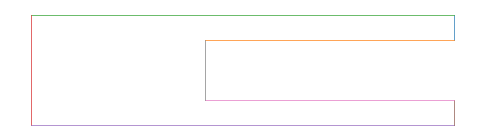

[SAVED] data\test\Model_#19_01_300_Vertical_right.png


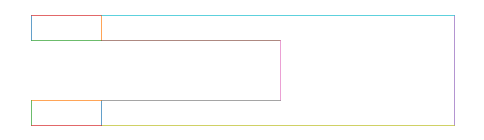

[SAVED] data\test\Model_#19_01_300_Vertical_back.png


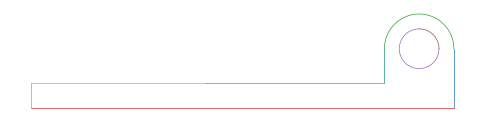

[SAVED] data\test\Model_#7_02_458_front.png


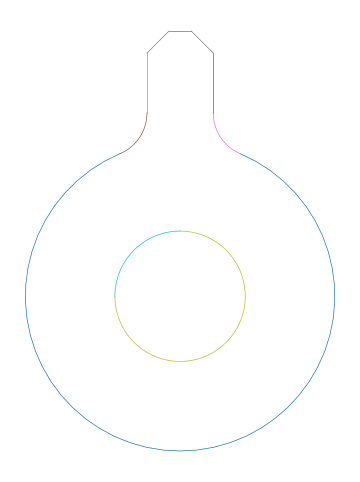

[SAVED] data\test\Model_#7_02_458_right.png


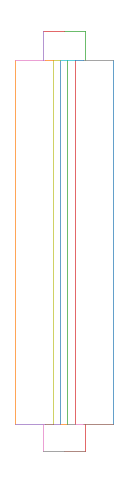

In [11]:
import os
import numpy as np
import pandas as pd

import ezdxf
import torch
from torch_geometric.data import Data

import matplotlib.pyplot as plt

import learning_fn
import extract_dxf_fn
from extract_dxf_fn import os, glob, load_step_file, extract_all_edges, save_edges_as_dxf_all_types

# 설정
views = ['bottom', 'top', 'front', 'left', 'right', 'back']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
step_folder = r'data\test'

# 모델 로드
model_paths = [f'model/best_model_fold_preprocessing{i}.pth' for i in range(5)]
models = []
dummy_data = learning_fn.build_graph_data(next(iter([
    os.path.join(step_folder, f)
    for f in os.listdir(step_folder)
    if f.endswith(('.stp', '.step'))
])))
in_channels = dummy_data[0].shape[1]
for mpath in model_paths:
    model = learning_fn.GINViewModel(in_channels).to(device)
    model.load_state_dict(torch.load(mpath, map_location=device))
    model.eval()
    models.append(model)

# 결과 저장 리스트
results = []

# 파일별 처리
for fname in os.listdir(step_folder):
    if not fname.lower().endswith(('.stp', '.step')):
        continue

    step_path = os.path.join(step_folder, fname)
    try:
        x, edge_index = learning_fn.build_graph_data(step_path)
        data = Data(x=x, edge_index=edge_index)
        data.filename = fname
        data = data.to(device)

        with torch.no_grad():
            preds = [model(data).cpu().numpy().flatten() for model in models]
            avg_pred = np.mean(preds, axis=0)

        row = {'filename': fname}
        for i, view in enumerate(views):
            row[view] = float(avg_pred[i])
        results.append(row)

        print(f"[DONE] {fname}")

    except Exception as e:
        print(f"[FAIL] {fname} → {type(e).__name__}: {e}")

# 결과 CSV 저장
df = pd.DataFrame(results)
output_path = os.path.join(step_folder, 'all_predictions.csv')
df.to_csv(output_path, index=False)
print(f"\n모든 결과 저장 완료: {output_path}")



# 2) 처리할 STEP 파일 목록 수집
patterns = ["*.stp", "*.step"]  # 필요시 확장자 추가
step_files = []
for pat in patterns:
    step_files.extend(glob.glob(os.path.join(step_folder, pat)))

# 3) 뷰 정의
view_directions = {
    "front":  extract_dxf_fn.gp_Dir(0,  1, 0),
    "back":   extract_dxf_fn.gp_Dir(0, -1, 0),
    "left":   extract_dxf_fn.gp_Dir(-1, 0, 0),
    "right":  extract_dxf_fn.gp_Dir(1,  0, 0),
    "top":    extract_dxf_fn.gp_Dir(0,  0, 1),
    "bottom": extract_dxf_fn.gp_Dir(0,  0,-1),
}

# 4) 파일별 반복 처리
for step_path in step_files:
    base = os.path.splitext(os.path.basename(step_path))[0]
    try:
        shape = load_step_file(step_path)
    except RuntimeError as e:
        print(e)
        continue

    for name, direction in view_directions.items():
        edges = extract_all_edges(shape, direction)
        dxf_name = f"{base}_{name}_view_all_edges.dxf"
        dxf_path = os.path.join(step_folder, dxf_name)
        save_edges_as_dxf_all_types(edges, dxf_path)

result_csv = output_path
dxf_folder = step_folder
output_img_folder = step_folder
score_threshold = 0.35

os.makedirs(output_img_folder, exist_ok=True)

# View 이름
views = ['bottom', 'top', 'front', 'left', 'right', 'back']

# 결과 CSV 로드
df = pd.read_csv(result_csv)

# DXF 시각화 함수
def render_and_plot_dxf(dxf_path, out_path, title=None):
    try:
        doc = ezdxf.readfile(dxf_path)
        msp = doc.modelspace()
        fig, ax = plt.subplots(figsize=(6, 6))
        for e in msp:
            if e.dxftype() in ['LWPOLYLINE', 'POLYLINE']:
                points = [(pt[0], pt[1]) for pt in e.get_points()] if e.dxftype() == 'LWPOLYLINE' else [
                    (v.dxf.location.x, v.dxf.location.y) for v in e.vertices()]
                if len(points) >= 2:
                    xs, ys = zip(*points)
                    ax.plot(xs, ys, linewidth=0.5)
            elif e.dxftype() == 'LINE':
                start = e.dxf.start
                end = e.dxf.end
                ax.plot([start[0], end[0]], [start[1], end[1]], linewidth=0.5)
            elif e.dxftype() == 'CIRCLE':
                c = e.dxf.center
                r = e.dxf.radius
                circle = plt.Circle((c[0], c[1]), r, fill=False, linewidth=0.5)
                ax.add_patch(circle)
        ax.set_aspect('equal')
        ax.axis('off')
        if title:
            ax.set_title(title)
        plt.savefig(out_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
        print(f"[SAVED] {out_path}")
        plt.show()
        plt.close()
    except Exception as ex:
        print(f"[FAIL] {dxf_path} → {type(ex).__name__}: {ex}")

# 조건에 맞는 결과 처리
for _, row in df.iterrows():
    fname = os.path.splitext(row['filename'])[0]
    for view in views:
        if row[view] >= score_threshold:
            dxf_name = f"{fname}_{view}_view_all_edges.dxf"
            dxf_path = os.path.join(dxf_folder, dxf_name)
            out_img = os.path.join(output_img_folder, f"{fname}_{view}.png")
            if os.path.exists(dxf_path):
                render_and_plot_dxf(dxf_path, out_img)
            else:
                print(f"[MISSING] {dxf_path}")



Loading training data...
No training files found. Skipping training.
Loading test data...
Evaluating result for first test file...

[테스트 1] 실제 중요 치수 정보:
  id=62 (relation) | type=LINE_LINE_PARALLEL, distance=6.000
  id=23 (relation) | type=LINE_LINE_PARALLEL, distance=5.000
  id=24 (relation) | type=LINE_LINE_PARALLEL, distance=8.000
  id=58 (relation) | type=LINE_LINE_PARALLEL, distance=8.500
  id=66 (relation) | type=LINE_LINE_PARALLEL, distance=16.000
  id=48 (relation) | type=LINE_LINE_PARALLEL, distance=23.500
  id=82 (relation) | type=LINE_LINE_PARALLEL, distance=18.000

예측 상위 10개 index: [10, 89, 57, 8, 96, 95, 73, 76, 98, 78]
실제 중요 치수 index: [0, 1, 25, 35, 39, 43, 59]
정답 개수(top-10, type+value 기준): 1 / 7

[예측 상위 10개 형상/관계 정보]
1. id: 33, type: LINE_LINE_PARALLEL, distance: 2.5
2. id: 112, type: LINE_LINE_PARALLEL, distance: 12.5
3. id: 80, type: LINE_LINE_PARALLEL, distance: 20.5
4. id: 31, type: LINE_LINE_PARALLEL, distance: 5.0
5. id: 119, type: LINE_LINE_PARALLEL, distance: 4.5

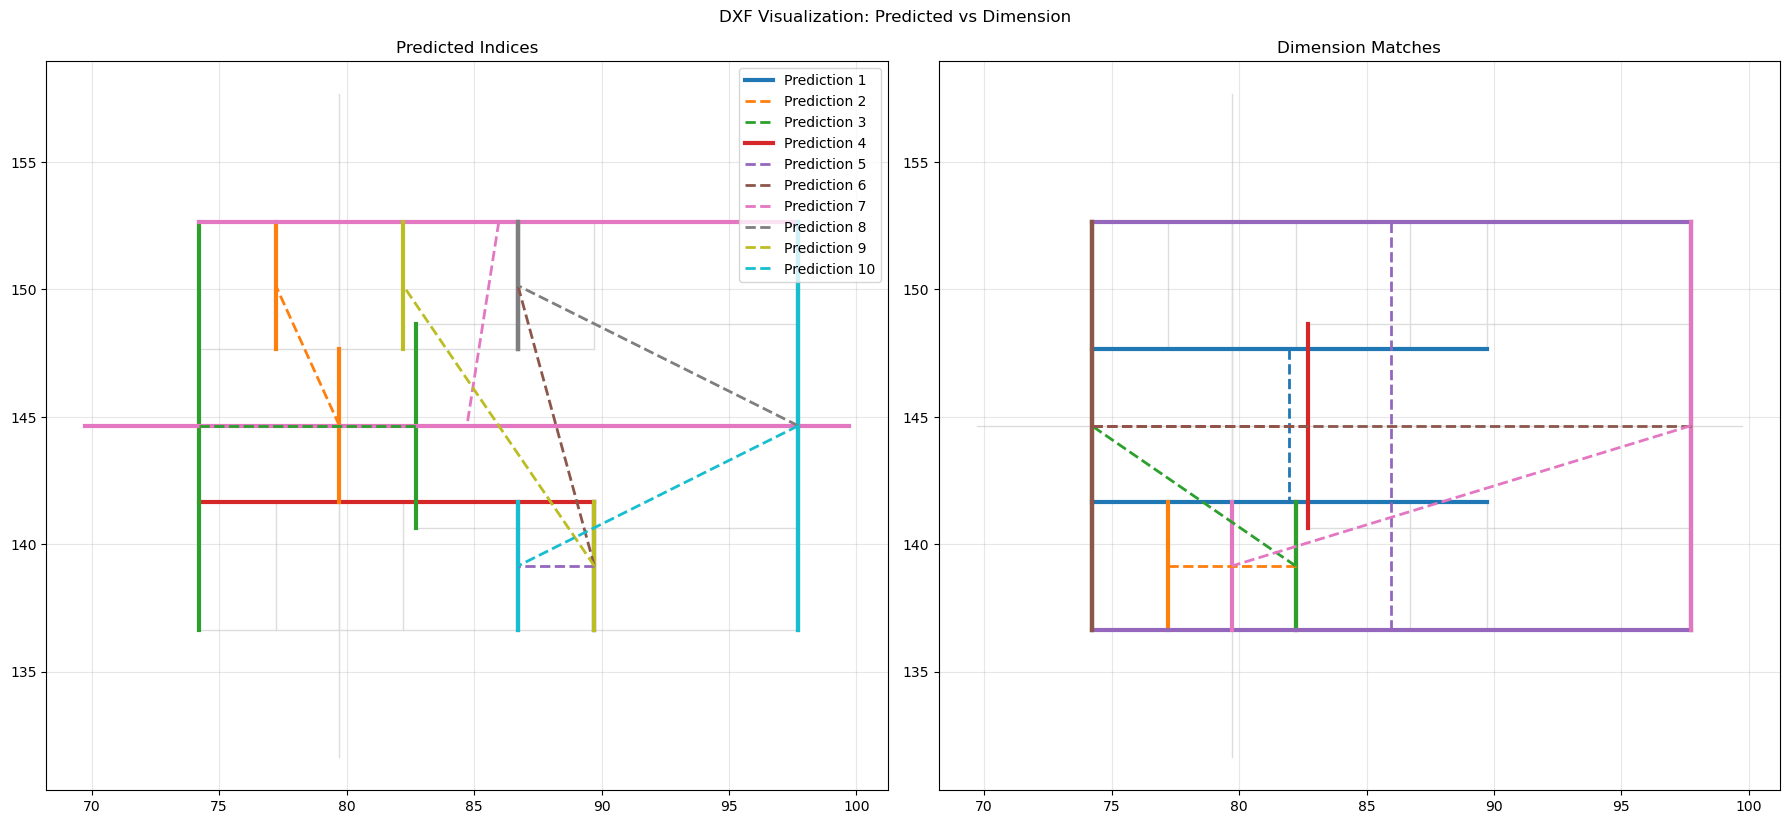


[테스트 2] 실제 중요 치수 정보:
  id=6 (feature) | type=CIRCLE, radius=2.900
  id=12 (relation) | type=LINE_LINE_PARALLEL, distance=6.000
  id=26 (relation) | type=LINE_LINE_PARALLEL, distance=28.000
  id=16 (relation) | type=LINE_LINE_PARALLEL, distance=3.000
  id=26 (relation) | type=LINE_LINE_PARALLEL, distance=28.000
  id=23 (relation) | type=LINE_LINE_PARALLEL, distance=10.000
  id=7 (feature) | type=ARC, radius=8.000

예측 상위 10개 index: [0, 1, 20, 16, 11, 17, 24, 12, 25, 2]
실제 중요 치수 index: [0, 1, 2, 6, 13, 16]
정답 개수(top-10, type+value 기준): 5 / 6

[예측 상위 10개 형상/관계 정보]
1. id: 6, type: CIRCLE, radius: 2.900000000000006
2. id: 7, type: ARC, radius: 8.0
3. id: 30, type: LINE_LINE_PARALLEL, distance: 3.000000000000149
4. id: 26, type: LINE_LINE_PARALLEL, distance: 28.000000000000117
5. id: 21, type: LINE_LINE_PARALLEL, distance: 23.00000000000012
6. id: 27, type: LINE_LINE_PARALLEL, distance: 25.00000000000018
7. id: 34, type: LINE_LINE_PARALLEL, distance: 18.000000000000128
8. id: 22, type: LINE_

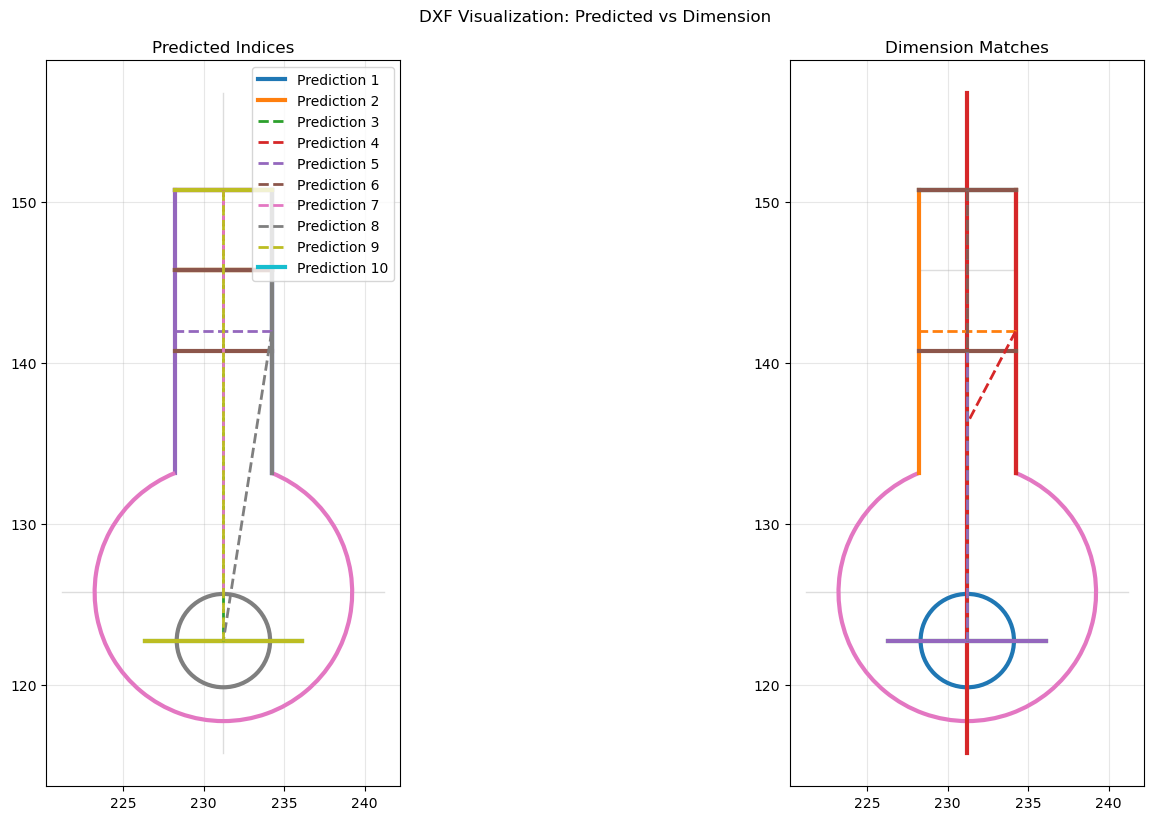


[테스트 3] 실제 중요 치수 정보:
  id=33 (relation) | type=LINE_LINE_PARALLEL, distance=8.000
  id=325 (relation) | type=ARC_CENTER_LINE_DISTANCE, distance=15.000
  id=345 (relation) | type=LINE_CIRCLE_DISTANCE, distance=27.000
  id=333 (relation) | type=ARC_CENTER_LINE_DISTANCE, distance=16.000
  id=115 (relation) | type=ARC_CENTER_LINE_DISTANCE, distance=6.000
  id=115 (relation) | type=ARC_CENTER_LINE_DISTANCE, distance=6.000
  id=161 (relation) | type=LINE_LINE_PARALLEL, distance=26.000
  id=164 (relation) | type=ARC_CENTER_LINE_DISTANCE, distance=52.000
  id=172 (relation) | type=LINE_LINE_PARALLEL, distance=52.000
  id=79 (relation) | type=LINE_LINE_PARALLEL, distance=24.000
  id=101 (relation) | type=LINE_LINE_PARALLEL, distance=18.000
  id=18 (feature) | type=ARC, radius=6.000
  id=21 (feature) | type=ARC, radius=4.000
  id=19 (feature) | type=ARC, radius=9.000

예측 상위 10개 index: [140, 306, 80, 322, 83, 84, 227, 58, 93, 36]
실제 중요 치수 index: [9, 55, 91, 137, 140, 148, 301, 309, 321]
정답 개수(to

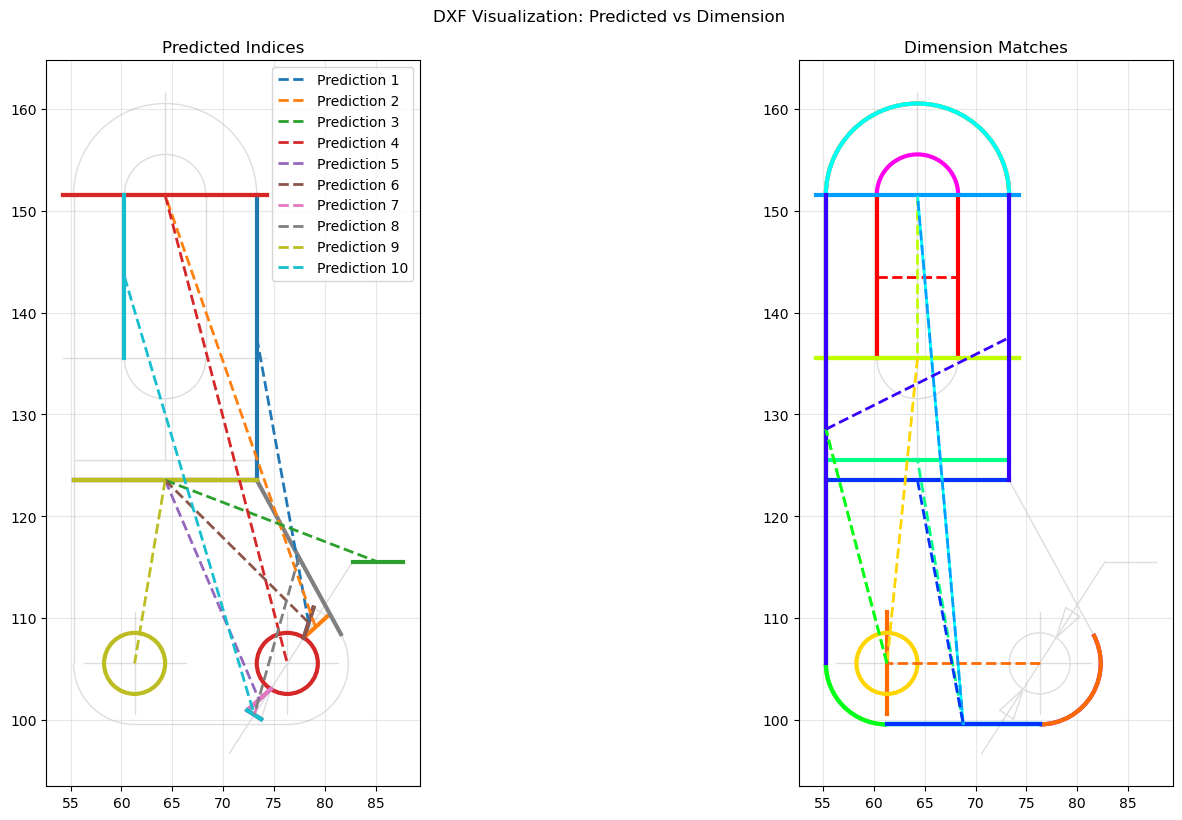


[테스트 4] 실제 중요 치수 정보:
  id=25 (relation) | type=LINE_LINE_PARALLEL, distance=65.200
  id=20 (relation) | type=LINE_LINE_PARALLEL, distance=34.000
  id=33 (relation) | type=LINE_LINE_PARALLEL, distance=55.200

예측 상위 10개 index: [7, 10, 11, 32, 33, 38, 47, 13, 29, 36]
실제 중요 치수 index: [2, 7, 15]
정답 개수(top-10, type+value 기준): 3 / 3

[예측 상위 10개 형상/관계 정보]
1. id: 25, type: LINE_LINE_PARALLEL, distance: 65.2
2. id: 28, type: LINE_LINE_PARALLEL, distance: 60.20000000000009
3. id: 29, type: LINE_LINE_PARALLEL, distance: 57.199999999999946
4. id: 50, type: LINE_LINE_PARALLEL, distance: 55.20000000000009
5. id: 51, type: LINE_LINE_PARALLEL, distance: 52.199999999999946
6. id: 56, type: LINE_LINE_PARALLEL, distance: 24.0
7. id: 65, type: LINE_LINE_PARALLEL, distance: 34.0
8. id: 31, type: LINE_LINE_PARALLEL, distance: 32.60000000000001
9. id: 47, type: LINE_LINE_PARALLEL, distance: 29.0
10. id: 54, type: LINE_LINE_PARALLEL, distance: 10.0


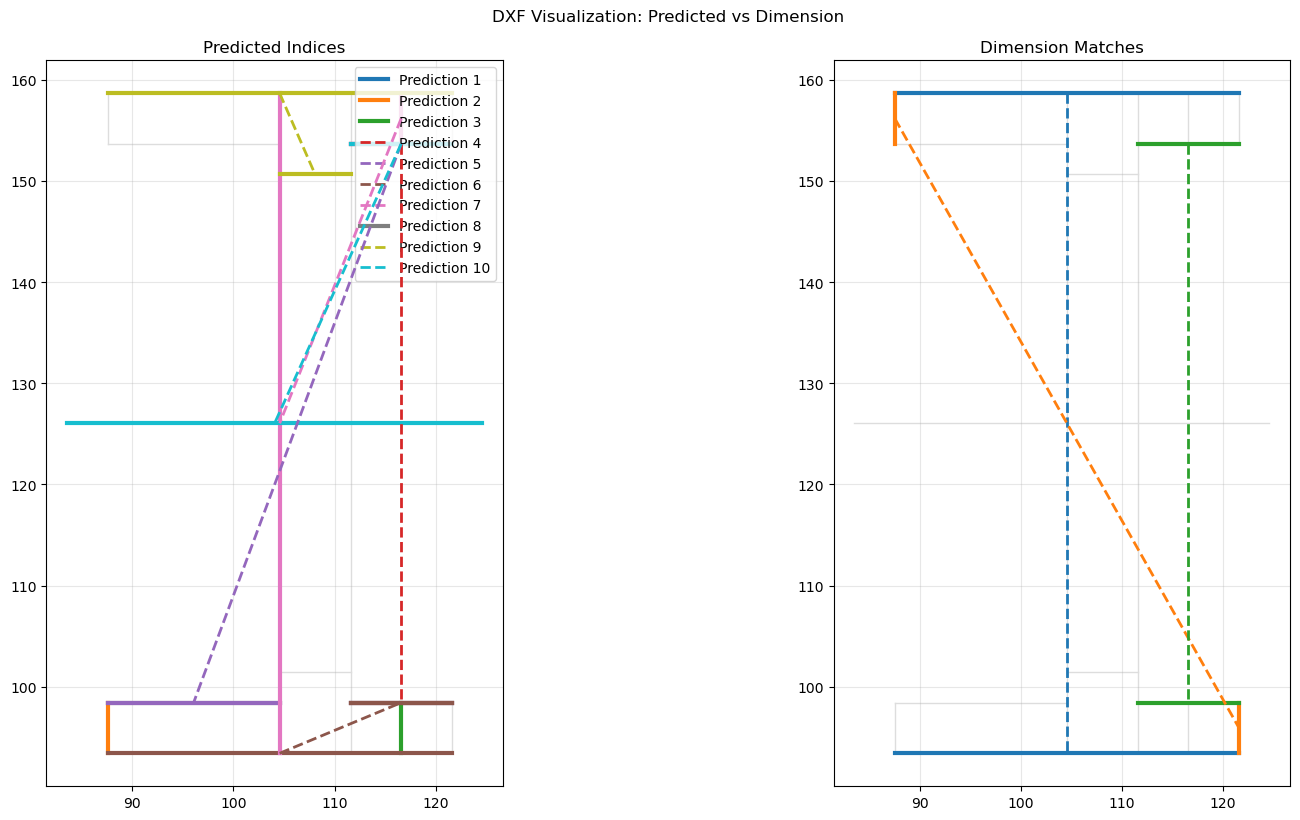


[테스트 5] 실제 중요 치수 정보:
  id=27 (relation) | type=LINE_LINE_PARALLEL, distance=5.000
  id=77 (relation) | type=LINE_LINE_PARALLEL, distance=65.400
  id=19 (feature) | type=ARC, radius=8.000
  id=57 (relation) | type=LINE_LINE_PARALLEL, distance=5.000
  id=38 (relation) | type=LINE_LINE_PARALLEL, distance=55.400
  id=27 (relation) | type=LINE_LINE_PARALLEL, distance=5.000
  id=45 (relation) | type=LINE_LINE_PARALLEL, distance=22.000

예측 상위 10개 index: [0, 56, 19, 17, 74, 40, 73, 38, 39, 70]
실제 중요 치수 index: [0, 6, 17, 24, 36, 56]
정답 개수(top-10, type+value 기준): 4 / 6

[예측 상위 10개 형상/관계 정보]
1. id: 19, type: ARC, radius: 8.0
2. id: 77, type: LINE_LINE_PARALLEL, distance: 65.39999999999989
3. id: 40, type: LINE_LINE_PARALLEL, distance: 60.3999999999999
4. id: 38, type: LINE_LINE_PARALLEL, distance: 55.40000000000017
5. id: 95, type: ARC_CENTER_LINE_DISTANCE, distance: 57.3999999999999
6. id: 61, type: ARC_CENTER_LINE_DISTANCE, distance: 52.40000000000017
7. id: 94, type: ARC_CENTER_LINE_DISTANCE,

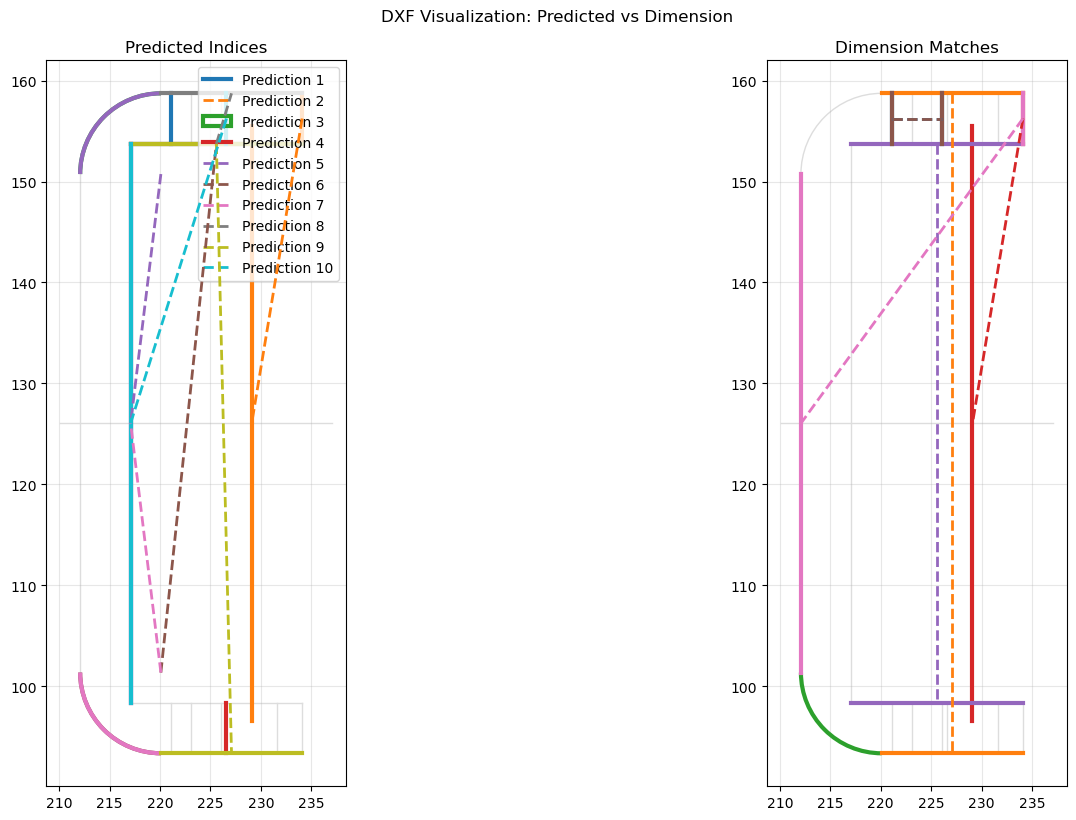

In [ ]:
import os
import glob

from model.train_test import train_model, test_model
from model.dataset import DXFGraphDataset, build_combined_data
from model.model import EnsembleMLP
from config import TRAIN_DXF_DIR, TEST_DXF_DIR, MODEL_SAVE_PATH, EPOCHS, RETRAIN

from dxf_parser.id_generator import IDGenerator

def main():

    print("Loading training data...")
    train_files = glob.glob(os.path.join(TRAIN_DXF_DIR, '*.dxf'))
    if not train_files:
        print("No training files found. Skipping training.")
        train_dataset = None
    else:

        if RETRAIN:
            train_dataset = DXFGraphDataset(train_files)

            if train_dataset:
                print("Training model...")
                train_model(train_dataset, MODEL_SAVE_PATH, epochs=EPOCHS)
            else:
                print("Cannot retrain: training dataset is empty.")
                
        elif not os.path.exists(MODEL_SAVE_PATH):
            if train_dataset:
                
                print(f"Model file not found. Training new model at {MODEL_SAVE_PATH}...")
                train_model(train_dataset, MODEL_SAVE_PATH, epochs=EPOCHS)
            else:
                print("No model found and no training data available to train a model.")
                return
        else:
            print(f"Using existing trained model: {MODEL_SAVE_PATH}")

    print("Loading test data...")
    test_files = glob.glob(os.path.join(TEST_DXF_DIR, '*.dxf'))
    if not test_files:
        print("No test files found. Aborting.")
        return

    print("Evaluating result for first test file...")    
    test_dataset = DXFGraphDataset(test_files)
    test_model(test_dataset, MODEL_SAVE_PATH)


if __name__ == "__main__":
    main()
